# Management Summary

The analysed dataset encompasses trip data from New York City taxis. It holds a total of approximately 305.000 taxi trips. After performing data cleaning for trips with negative or zero fare amounts, total amounts, trip durations and trip trip distances as well as negative tips there are nearly 295.000 trips remaining. More analysis is necessary to infer how those negative values arise and what actions to be taken to reduce faulty data collection for a better database in the future. There are also trips with zero passengers which make no sense as well and were remove. It is unclear how those come to pass and further analysis is needed as well. There is also a type of payment called flex fare which apparently leads to `NaN` values in some columns, here of interest is `passenger_count`, which were imputed using mode. More domain knowledge is necessary to confirm this is the right decision. With the remaining data trends in passenger numbers, fare prices, trip distances and durations were extracted. It shows that passenger and trip numbers are reducing slightly over time. This is mainly driven by less weekday trips which are somewhat compensated by weekend trips and may be an overall result of home office policies. Fare prices are going up, likely to combat the reduction in trips and because of inflation. Tips are increasing as well. Using this information there could be more analysis done in how revenues behaves, what influences customers to give more tips even though prices are increasing and how to use the increase in weekend trips to an advantage.

## Preface

The overall goal of the following notebook is the analysis of a New York City taxi dataset to gather insights and trends. Therefore a overall look of the data will be taken, abnormalities identified, possible reasons and improvements for those abnormalities searched for and some time series analysis done to identify general developments in the data.

In [1]:
# install or update necessary packages if missing
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Data and workflow preparation 

First import all necessary packages for further analysis. Afterwards read the data and get an overview of the structure. Use this to infer what steps to take.

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown

# Read data, using parse_dates and date_format for column 2 and 3 after first check showed they're datetimes.
# Two categorical columns are read as float, so they're changed to int64 as all other ID columns. All remaining columns are read correctly.
url = 'https://github.com/Droelf-source/tlc-taxi/blob/main/data/Yellow_Taxi_Assignment.csv?raw=true'
parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
dtypes = {'passenger_count' : 'Int64', 'RatecodeID' : 'Int64'}
df = pd.read_csv(url, parse_dates=parse_dates, date_format="%Y-%m-%d %H:%M:%S", dtype=dtypes)

# Display info and data types for all columns to check if loaded correctly and to get a first look
display(Markdown("### Overview of dataset"))
display(HTML("<b style='color:blue'>Dataset info:</b>"))
display(df.info())
display(HTML("<b style='color:blue'>First and last five rows of dataset:</b>"))
display(df.head(5), df.tail(5))

### Overview of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        295465 non-null  Int64         
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             295465 non-null  Int64         
 6   store_and_fwd_flag     295465 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

None

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1,0.53,1,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1,1.05,1,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4,1.83,1,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1,2.30,1,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1,3.06,1,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
304973,1,2023-01-31 00:11:27,2023-01-31 00:38:56,1,9.90,99,N,48,47,1,35.5,0.0,0.5,0.00,0.0,1.0,37.00,0.0,0.0
304974,2,2023-01-31 16:06:08,2023-01-31 16:52:18,1,8.27,1,N,87,75,2,44.3,2.5,0.5,0.00,0.0,1.0,50.80,2.5,0.0
304975,2,2023-01-31 15:31:38,2023-01-31 15:44:48,1,0.71,1,N,236,236,2,12.1,0.0,0.5,0.00,0.0,1.0,16.10,2.5,0.0
304976,1,2023-01-31 20:35:17,2023-01-31 20:42:56,1,1.80,1,N,141,170,2,10.7,3.5,0.5,0.00,0.0,1.0,15.70,2.5,0.0
304977,1,2023-01-31 08:57:26,2023-01-31 09:25:33,1,6.70,1,N,236,114,1,32.4,2.5,0.5,7.28,0.0,1.0,43.68,2.5,0.0


## First look at the data

Before looking at the data contents it is noticeable that some columns have missing values, especially interesting is `passenger_count` which matches its missing values with `RatecodeID` and `store_and_fwd_flag`. Since a trip with missing values in `passenger_count` is propably unusable it may be exluded from the data. Therefore a check is made if any other columns hold meaningful values when `passenger_count` is missing and if `RatecodeID` and `store_and_fwd_flag` missing really match with `passenger_count` missing entries. The remaining columns with missing data `congestion_surcharge` and `airport_fee` are probably just not applicable for the trips where they are missing. If needed this will be verified at a later time.

In [3]:
# Filter all rows with missing passenger count
df_missing = df[df['passenger_count'].isna()]

# Info and description about df_missing
display(HTML("<b style='color:blue'>Dataset info for rows with missing passenger count:</b>"))
display(df_missing.info())

# How many rows for numerical and categorical columns contain zeros
numeric_cols = df.select_dtypes(include=['number']).columns
display(HTML("<b style='color:blue'>How many numerical rows are exactly zero?:</b>"))
display((df_missing[numeric_cols] == 0).sum())

# Check if payment_type == 0 holds true only if passenger_count, RatecodeID and store_and_fwd_flag are NaN
# since already established that NaN same for all three columns only one needs to be checked
payment_type_zero = (df["payment_type"] == 0)
passenger_count_nan = df['passenger_count'].isna()
display(HTML("<b style='color:blue'>Do NaN passenger and payment_type = 0 match?:</b>"))
display((payment_type_zero == passenger_count_nan).all())

<class 'pandas.core.frame.DataFrame'>
Index: 9513 entries, 37873 to 304957
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               9513 non-null   int64         
 1   tpep_pickup_datetime   9513 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  9513 non-null   datetime64[ns]
 3   passenger_count        0 non-null      Int64         
 4   trip_distance          9513 non-null   float64       
 5   RatecodeID             0 non-null      Int64         
 6   store_and_fwd_flag     0 non-null      object        
 7   PULocationID           9513 non-null   int64         
 8   DOLocationID           9513 non-null   int64         
 9   payment_type           9513 non-null   int64         
 10  fare_amount            9513 non-null   float64       
 11  extra                  9513 non-null   float64       
 12  mta_tax                9513 non-null   float64       
 13  ti

None

VendorID                    0
passenger_count             0
trip_distance             230
RatecodeID                  0
PULocationID                0
DOLocationID                0
payment_type             9513
fare_amount                 6
extra                    7611
mta_tax                   263
tip_amount               3589
tolls_amount             7885
improvement_surcharge       2
total_amount                1
congestion_surcharge        0
airport_fee                 0
dtype: Int64

np.True_

### Detailed analysis of columns with missing data

It can be seen that all rows with missing values in `passenger_count`, `RatecodeID` and `store_and_fwd_flag` match, so a detailed analysis for the other two is not needed. The fare amount and trip distances aren't just zero for all trips with missing passenger number, so it seems an actual trip has happened. Thus a general exclusion isn't appropriate and will only be done when a column with missing values is used explicitly. It can also be seen that `payment_type` for all trips was zero, which means a flex fare trip, and that this is exactly the amount of flex fare trips taken in the overall dataset. Hence a flex fare trip implies that information for these three columns aren't collected. It also enhances the point to not generally exclude them from further analysis. Since `passenger_count` will be used in coming analysis it is imputed using mode of `passenger_count` as it holds whole number values.


In [4]:
# Compute the mode
mode_value = df['passenger_count'].mode()[0]

# Impute passenger_count using mode
df['passenger_count'] = df['passenger_count'].fillna(mode_value)

### Distribution for numeric columns

Next the distribution of the numeric columns will be examined to see if there are any outliers. Therefore descriptive statistics and boxplots will be generated and evaluated.


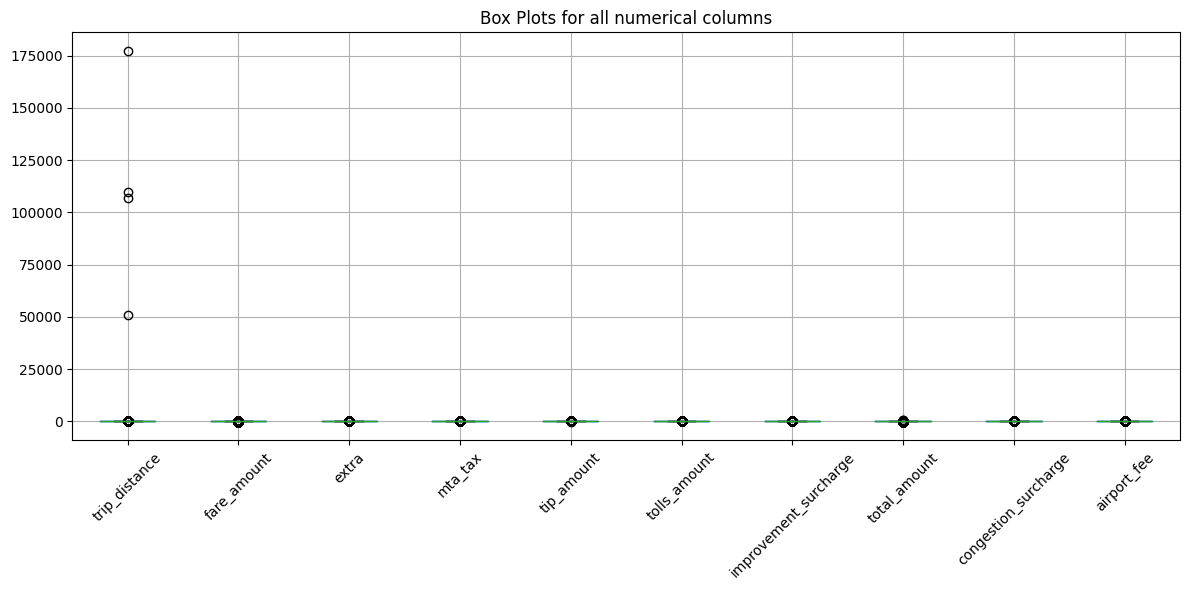

In [5]:
# Box plots for all numerical columns in one figure
plt.figure(figsize=(12, 6))
df.select_dtypes(include=['float64']).boxplot()
plt.xticks(rotation=45)
plt.title('Box Plots for all numerical columns')
plt.tight_layout()
plt.show()

There seem to be some heavy outliers in `trip_distance` which make an assessment for all other columns impossible. Since `trip_distance` is reported in miles according to the data dictionary a unit problem can be ruled out. The outliers in `trip_distance` will be excluded from the dataset for further analysis and plots will be shown for each column instead.

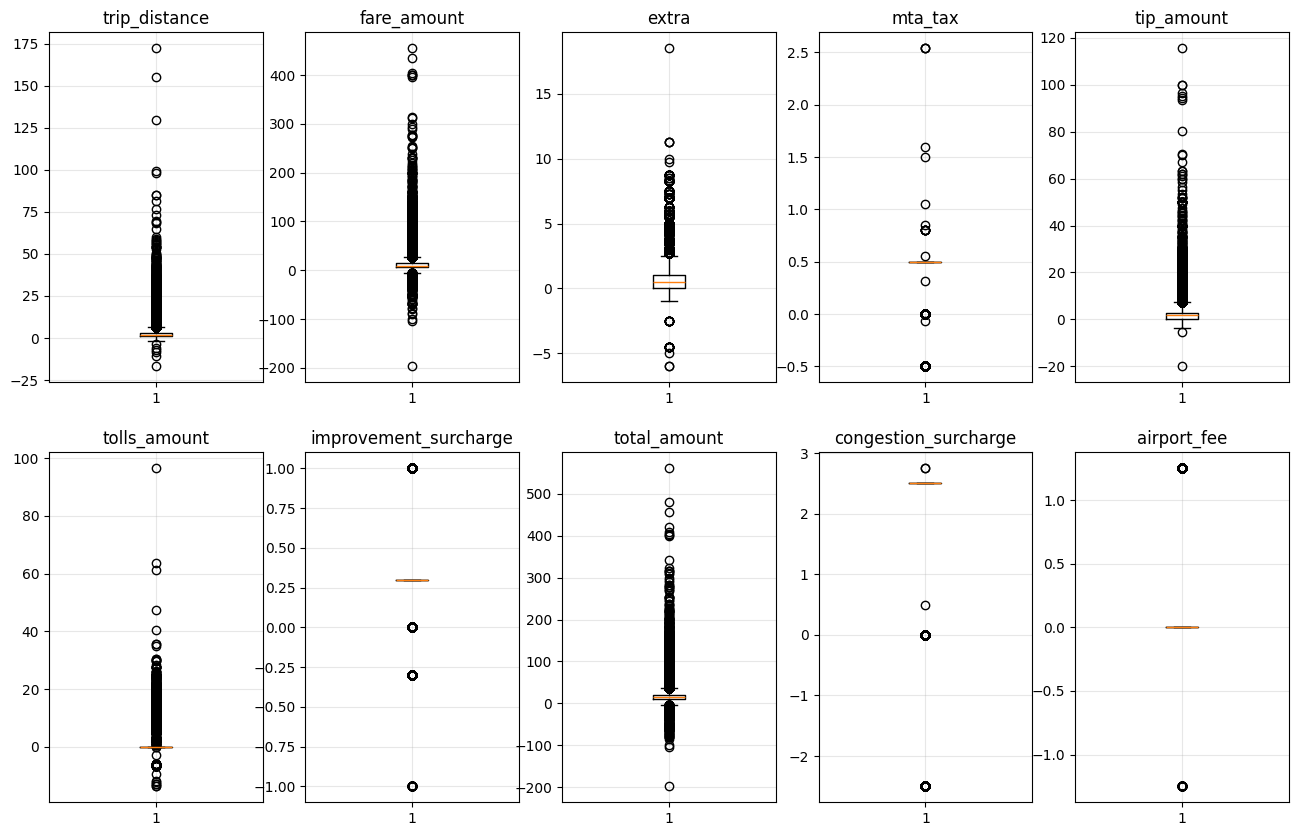

In [6]:
# Remove all rows where trip_distance is greater 10k miles
df = df[df['trip_distance'] < 10000]

# Create a plot for each numeric column for better readability
fig, axes = plt.subplots(2, 5, figsize=(16,10))
axes = axes.flatten() 

# plot generation, drop NA values for plot to work
for i, col in enumerate(df.select_dtypes(include=['float64']).columns):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'{col}')
    axes[i].grid(True, alpha=0.3)

In [7]:
# Display some descriptive statistics 
display(HTML("<b style='color:blue'>Descriptive statistics of numerical columns:</b>"))
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,304974.000000,304974,304974,304974.0,304974.000000,295465.0,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,304974.000000,232346.000000,106217.000000
mean,1.672782,2020-07-16 11:48:35.438326016,2020-07-16 12:05:17.262117632,1.464187,3.128674,1.142931,163.744860,160.988451,1.240480,13.510020,0.903518,0.492755,2.224005,0.390720,0.312725,19.050273,2.241650,0.085815
min,1.000000,2018-01-01 00:25:49,2018-01-01 00:38:59,0.0,-16.860000,1.0,1.000000,1.000000,0.000000,-197.000000,-6.000000,-0.500000,-20.000000,-13.750000,-1.000000,-198.550000,-2.500000,-1.250000
25%,1.000000,2019-04-08 09:14:05,2019-04-08 09:29:00.750000128,1.0,1.000000,1.0,121.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,10.800000,2.500000,0.000000
50%,2.000000,2020-07-17 16:59:19.500000,2020-07-17 17:11:38.500000,1.0,1.730000,1.0,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.860000,0.000000,0.300000,14.300000,2.500000,0.000000
75%,2.000000,2021-10-24 11:29:50.500000,2021-10-24 11:42:53.249999872,1.0,3.210000,1.0,234.000000,234.000000,2.000000,15.000000,1.000000,0.500000,2.950000,0.000000,0.300000,20.760000,2.500000,0.000000
max,6.000000,2023-01-31 23:57:28,2023-02-01 00:09:12,6.0,172.220000,99.0,265.000000,265.000000,5.000000,455.000000,18.500000,2.540000,115.560000,96.550000,1.000000,561.490000,2.750000,1.250000
std,0.514071,NaN,NaN,1.094015,4.059540,2.969941,66.570219,70.975938,0.528241,12.636512,1.185324,0.074024,2.765046,1.699557,0.110405,15.463757,0.791877,0.318628


### Results of data overview

The boxplots show some more outliers. For most columns this is understandable since they include various surcharges which may often be not applicable or incur only small values for short trips. Thus it is not straightforward to exclude them from the data. There are still some quite big trip distances which may explain the outliers for `fare_amount`, `tip_amount`and `total_amount` so now adjustments will be made for now. But there are also negative values for all variables. Small negative values may make sense in a kind of refund scenario but for sake of simplicity all negative values will be excluded for variables `trip_distance`, `fare_amount`, `tip_amount`and `total_amount` as well as zero values. It is assumed that negative values in other variables are correct as long as the `total_amount` is positive.

After taking a first look at the descriptive statistics it can be seen there are roughly 305k recorded trips, starting at the beginning of 2018 and ending at the beginning of 2023. Since total paid amounts are already calculated and trip distance is provided it stands out that trip time is missing as well as some kind of average speed. A weekday/weekend classification will also be added for use in later analysis, e. g. effect on trip time or fare prices, as well as paid amount without tips. These will be calculated next. Furthermore an overview of the unique values in all integer/categorical columns will be taken to infer what further directions to take. Also it will be checked if there are negative values in trip time and amount before tips and if true, those rows will be excluded from the dataset as well.

In [8]:
# Remove negative and zero values for numerical columns where they don't make sense
filter_cols = ["trip_distance", "fare_amount", "total_amount"]
df = df[(df[filter_cols] > 0).all(axis=1)]
# Zero tips are okay
df = df[df["tip_amount"] >= 0]

# Add weekday/weekend classification and fare amount before tips. The pickup time will be used to generate 
# the weekdays as it will be, assumedly, the relevant point in time where most other metrics are set
df["weekday"] = df["tpep_pickup_datetime"].dt.weekday
df['weekday_flag'] = (df['weekday'] >= 5).astype(bool)
df["total_before_tip"] = df["total_amount"] - df["tip_amount"]

# Add trip time and average speed. Calculate trip time as dropoff - pickup in minutes and average speed as trip distance / trip time in hours
# Taxi trips presumably rarely last hours but speed is usually give in miles per hour (NYC/USA)
df["trip_time"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df["avg_speed"] = df["trip_distance"] / (df["trip_time"] / 60)

# Negative values in newly created features?
display(HTML("<b style='color:blue'>Distribution of newly created features:</b>"))
display(df[["trip_time", "avg_speed", "total_before_tip"]].describe())

C:\Users\aaron\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,trip_time,avg_speed,total_before_tip
count,300018.000000,3.000180e+05,300018.000000
mean,16.788271,inf,16.828712
std,60.172097,NaN,13.168456
min,-44.133333,-3.220200e+04,0.310000
25%,6.700000,7.922006e+00,9.800000
50%,11.083333,1.055172e+01,12.800000
75%,18.066667,1.437092e+01,18.300000
max,1439.866667,inf,467.910000


There are negative values in `trip_time` and `avg_speed`. Those rows will be removed from the data. There are also NaN in `avg_speed` which means there are trips with a duration of zero (since there are no trips with NaN distance). This may happen when a person gets in a taxi and out again before moving but still has to pay some kind of charge or the trip is recorded as soon as they enter. Since these may distort findings for further analysis and relationships the two columns will be restricted to positive values. In `total_before_tip` are no abnormal values.

In [9]:
# Use only positive values for time and speed
filter_cols = ["trip_time", "avg_speed", "total_before_tip"]
df = df[(df[filter_cols]>= 0).all(axis=1)]

# Unique values of vendor, passenger_count, ratecode_id and payment_type columns
df_selected = df.select_dtypes(include=['integer']).filter(regex='^(?!PU|D)')
unique_values = {col: df_selected[col].value_counts().sort_index() for col in df_selected.columns}
display(Markdown("### Unique values of categorical columns"))
display(HTML("<b style='color:blue'>Amount of different categorical values:</b>"))
display(unique_values)

# How many unique values of pickup and drop locations are there
display(HTML("<b style='color:blue'>Number of unique locations:</b>"))
display(df.filter(regex='Location').nunique())


### Unique values of categorical columns

{'VendorID': VendorID
 1    100700
 2    198301
 4       494
 5         3
 6       352
 Name: count, dtype: int64,
 'passenger_count': passenger_count
 0      5367
 1    220249
 2     42943
 3     11530
 4      5065
 5      8920
 6      5776
 Name: count, dtype: Int64,
 'RatecodeID': RatecodeID
 1     281804
 2       7070
 3        585
 4        298
 5        800
 99       204
 Name: count, dtype: Int64,
 'payment_type': payment_type
 0      9089
 1    214469
 2     74631
 3      1198
 4       463
 Name: count, dtype: int64,
 'weekday': weekday
 0    39643
 1    44084
 2    45630
 3    46499
 4    46561
 5    42230
 6    35203
 Name: count, dtype: int64}

PULocationID    249
DOLocationID    259
dtype: int64

#### Findings from analyzing categorical variables

At first glance the main vendors for taxi trips are those with ID 1 and 2 while all the others only had a negligible amount of provided trips. There are 5367 trips without passengers which neither coincide with unknown ratecodes (category 99) or voided payments (payment_type 6). Since recorded trips without passengers don't make sense they will be excluded for further analysis. I will check if they coincide with `store_and_fwd_flag == Y` to see if there are data transfer issues after having no server connection. After checking only a small amount of rows satisfy the condition so the problem arises somewhere else. 

Furthermore most trips where paid by credit card. Since `tip_amount` is only recorded for credit card tips an analysis regarding time and length of trip may provide insight with such a huge amount of credit card paid trips. It stands to reason that credit card paid trips also receive tips in this way. 

In [10]:
# Check if zero passengers are a storage problem, i.e. all have flag==Y
df_zerop = df[(df['passenger_count']==0)]
storage_flags = (df_zerop['store_and_fwd_flag'] == 'Y').sum()
display(HTML("<b style='color:blue'>Number of Y flags for zero passengers in a trip:</b>"))
display(storage_flags)

# Remove trips without passengers
df = df[(df['passenger_count']!=0)]

np.int64(179)

## Next steps

After data preparation is complete some time series analysis will be performed to see how passenger number, number of trips, fares and tips develops over time. The results will show if there are any trends useful for further analysis.

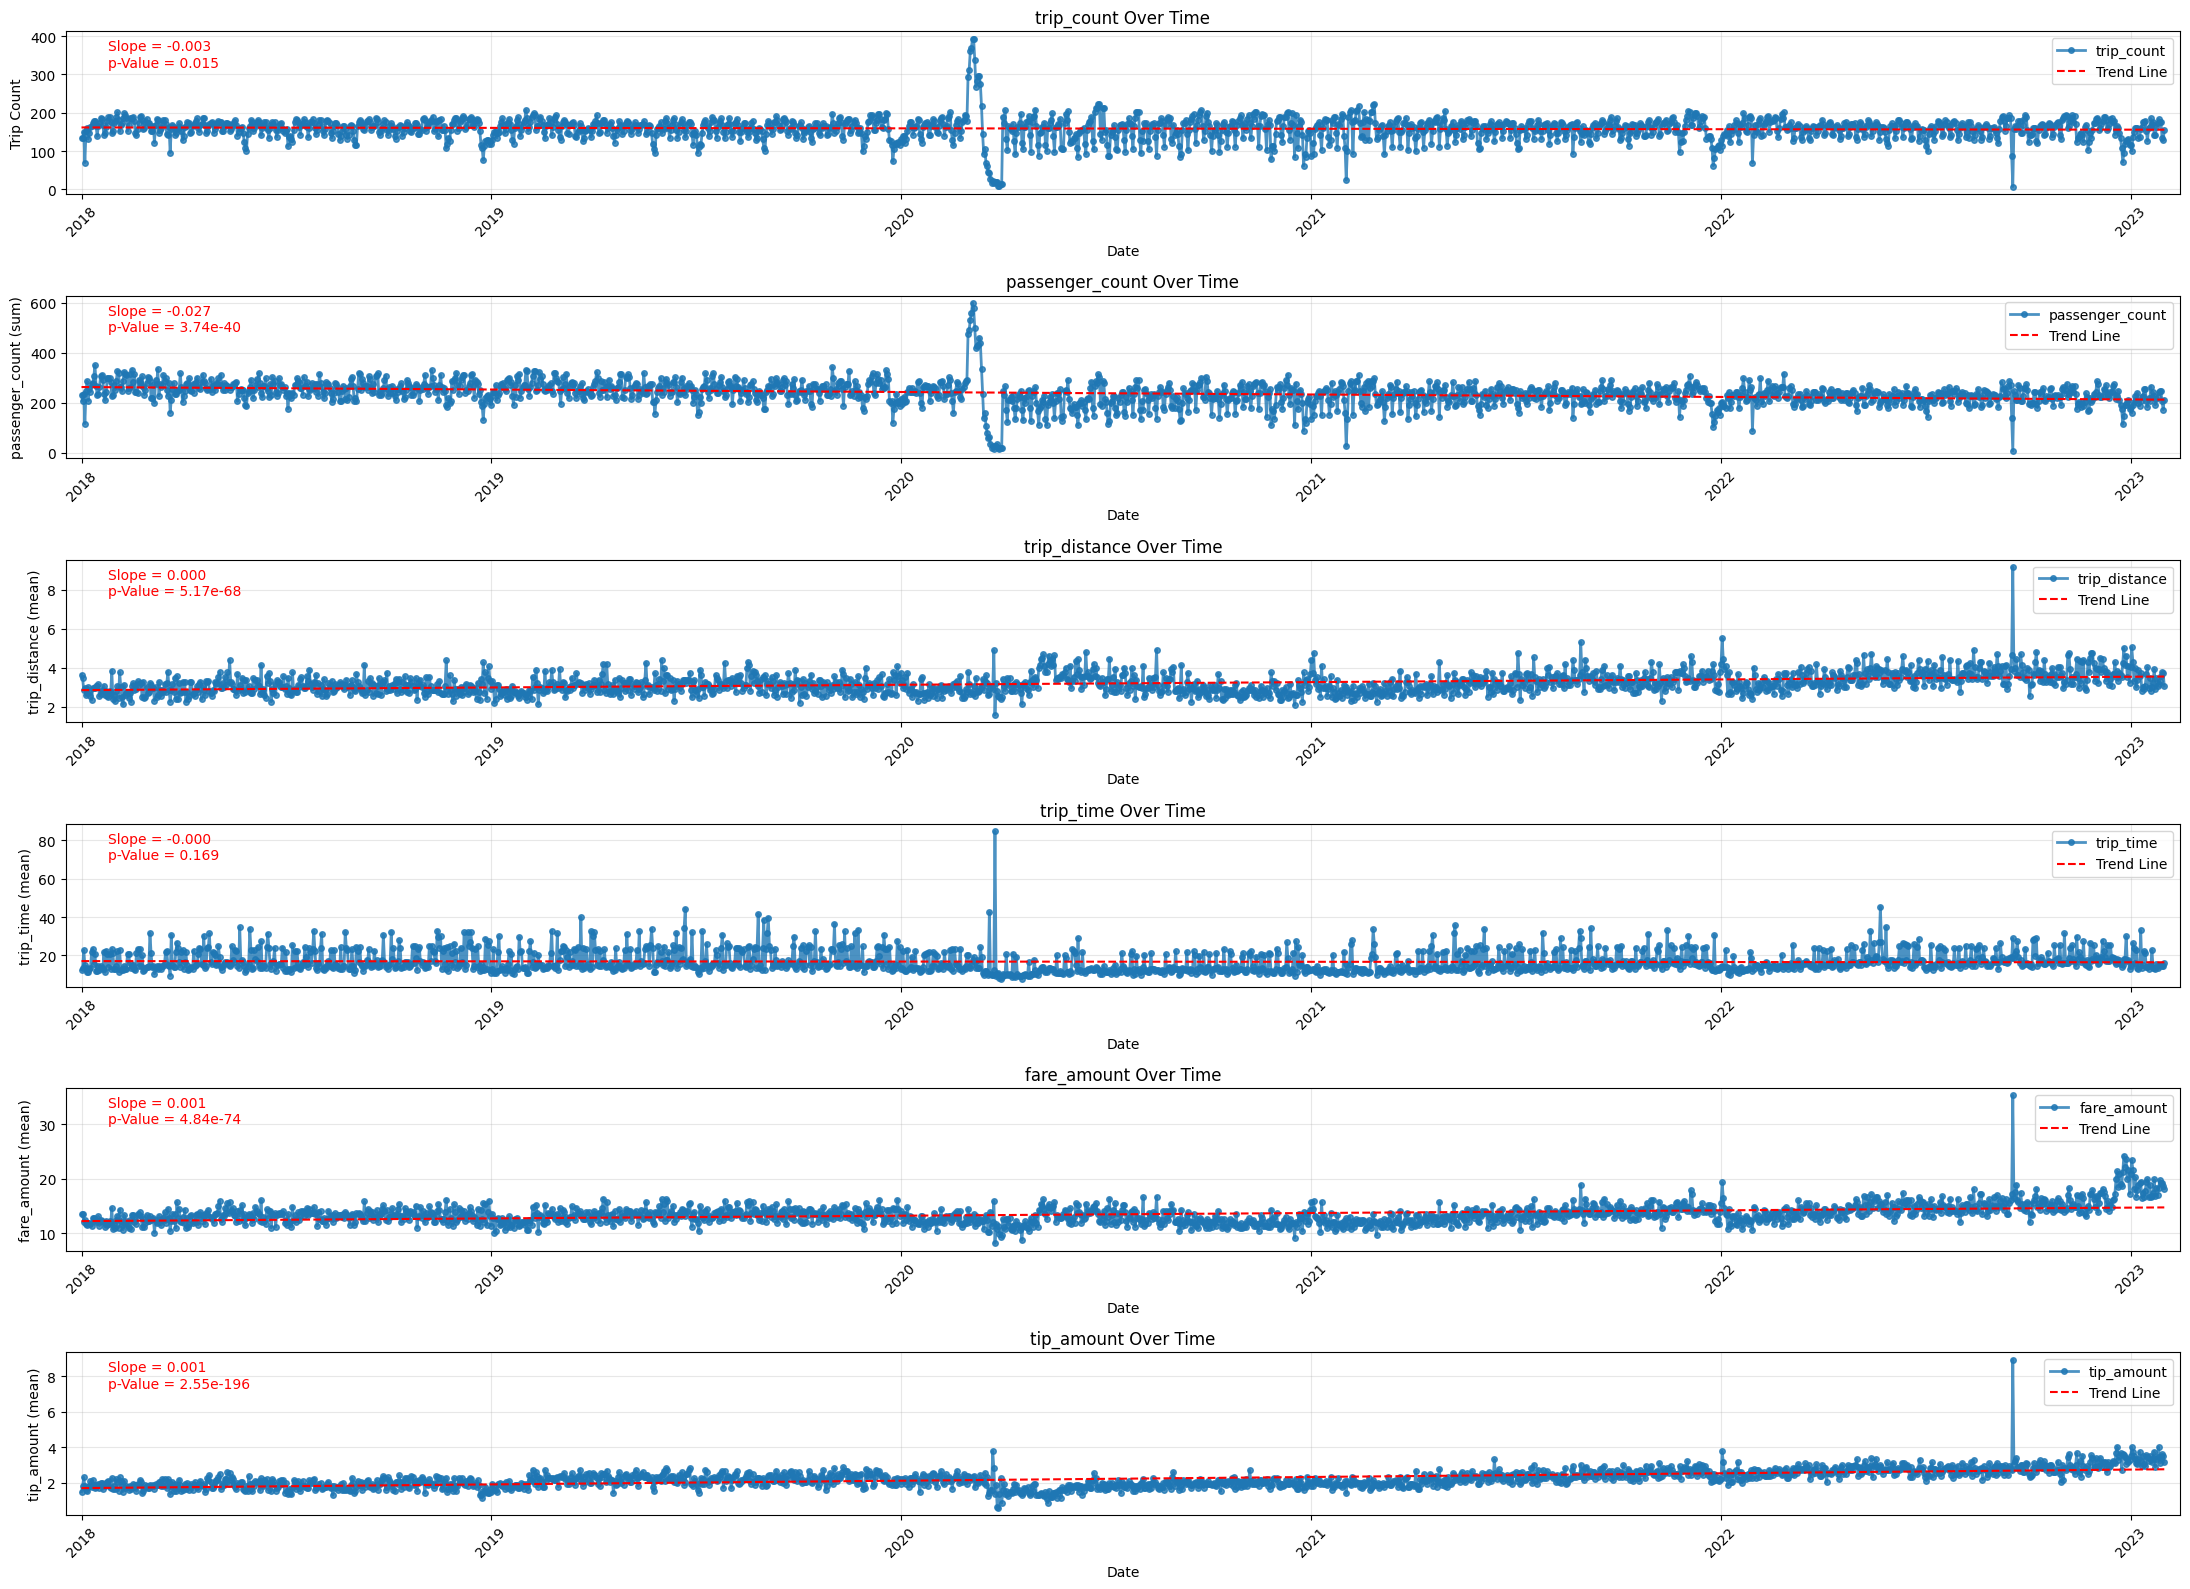

In [11]:
# Which features to analyze over time, with different aggregate functions
num_cols = ['trip_distance', 'trip_time', 'fare_amount', 'tip_amount']
cat_cols = ['trip_count', 'passenger_count']

# all features for aggregation
cols_analyze = cat_cols + num_cols

# Copy df to do manipulations for plotting
df_plot = df.copy().set_index('tpep_pickup_datetime')

# Add a new dummy column for number of trips per day
df_plot['trip_count'] = 1 

# Create different aggregations based on column type
agg_dict = {}
for col in cols_analyze:
    if col in num_cols:
        agg_dict[col] = ['mean']  # mean for numerical columns
    elif col == 'trip_count':
        agg_dict[col] = 'count' # count for trip counts
    else:
        agg_dict[col] = ['sum']  # sum for categorical columns

# Aggregate data for each day
agg_data = df_plot[cols_analyze].resample('D').agg(agg_dict)

# Prepare figure with 6 plots
fig, axes = plt.subplots(6, 1, figsize=(22, 16))
axes = axes.flatten()

# Prepare x-axis and x-values for OLS calculation
dates = agg_data.index
x_numeric = np.arange(len(dates))

# Calculate lower and upper x-axis limit for better readability
xlim_start = dates.min() - timedelta(weeks=2)
xlim_end = dates.max() + timedelta(weeks=2)

# Make a plot for each analyzed feature
for i, col in enumerate(cols_analyze):
    ax = axes[i] 

    # Use correct name depending on feature
    if col == 'trip_count':
        vals = agg_data[(col, 'count')]
        ylabel = 'Trip Count'
    elif col in num_cols:
        vals = agg_data[(col, 'mean')]
        ylabel = f'{col} (mean)'
    else:
        vals = agg_data[(col, 'sum')]
        ylabel = f'{col} (sum)'

    # Plot values
    ax.plot(dates, vals, marker='o', linewidth=2, markersize=4, 
            label=f'{col}', alpha=0.8)

    # Calculate trend using statsmodels OLS
    vals_clean = vals.fillna(0)
    X = sm.add_constant(x_numeric)
    model = sm.OLS(vals_clean, X).fit()
    trend_vals = model.predict(X)
    
    # Plot trend line
    ax.plot(dates, trend_vals, 'r--', label='Trend Line')
    
    # Add slope and p-value of slope in plot
    slope = model.params.iloc[1]
    p_value = model.pvalues.iloc[1]
    slope_text = f"Slope = {slope:.3f}\np-Value = {p_value:.3g}"
    ax.text(0.02, 0.95, slope_text, transform=ax.transAxes, 
            fontsize=10, color='red', verticalalignment='top')

    # Format plot
    ax.set_title(f'{col} Over Time', fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim([xlim_start, xlim_end])

plt.tight_layout()
plt.show()


It can be seen that only `trip_count` and `trip_time` have no significant linear trend over time. The amount of trips and how long trips take on average doesn't change (linearly) over time in the given data. All other viewed features have a significant trend although its only a very small positive one for distance, fare and tip amount. Looking at the plots for `fare_amount` and `tip_amount` it seems like the increases are happening mainly at the end of the years under review which coincides with the general inflation. For `trip_distance` it is just a steady albeit small increase over time with some outliers. Lastly `passenger_count` is the only feature with a significant downward slope. Since the amount of trips doesn't decrease this implies there are more one person trips over time. There are outliers with a sharp rise and consecutively sharp fall in all features around march 2020 which should mark the start of the Covid pandemic and, depending on what type of analysis are to be taken, may need handling.

Now differences between weekdays and weekends of the analyzed features will be checked with overall conclusions following afterwards. To ensure better readability data will be aggregated for each quarter. As the last quarter is incomplete and has only two days of data it will be excluded for the plots to avoid distortions.

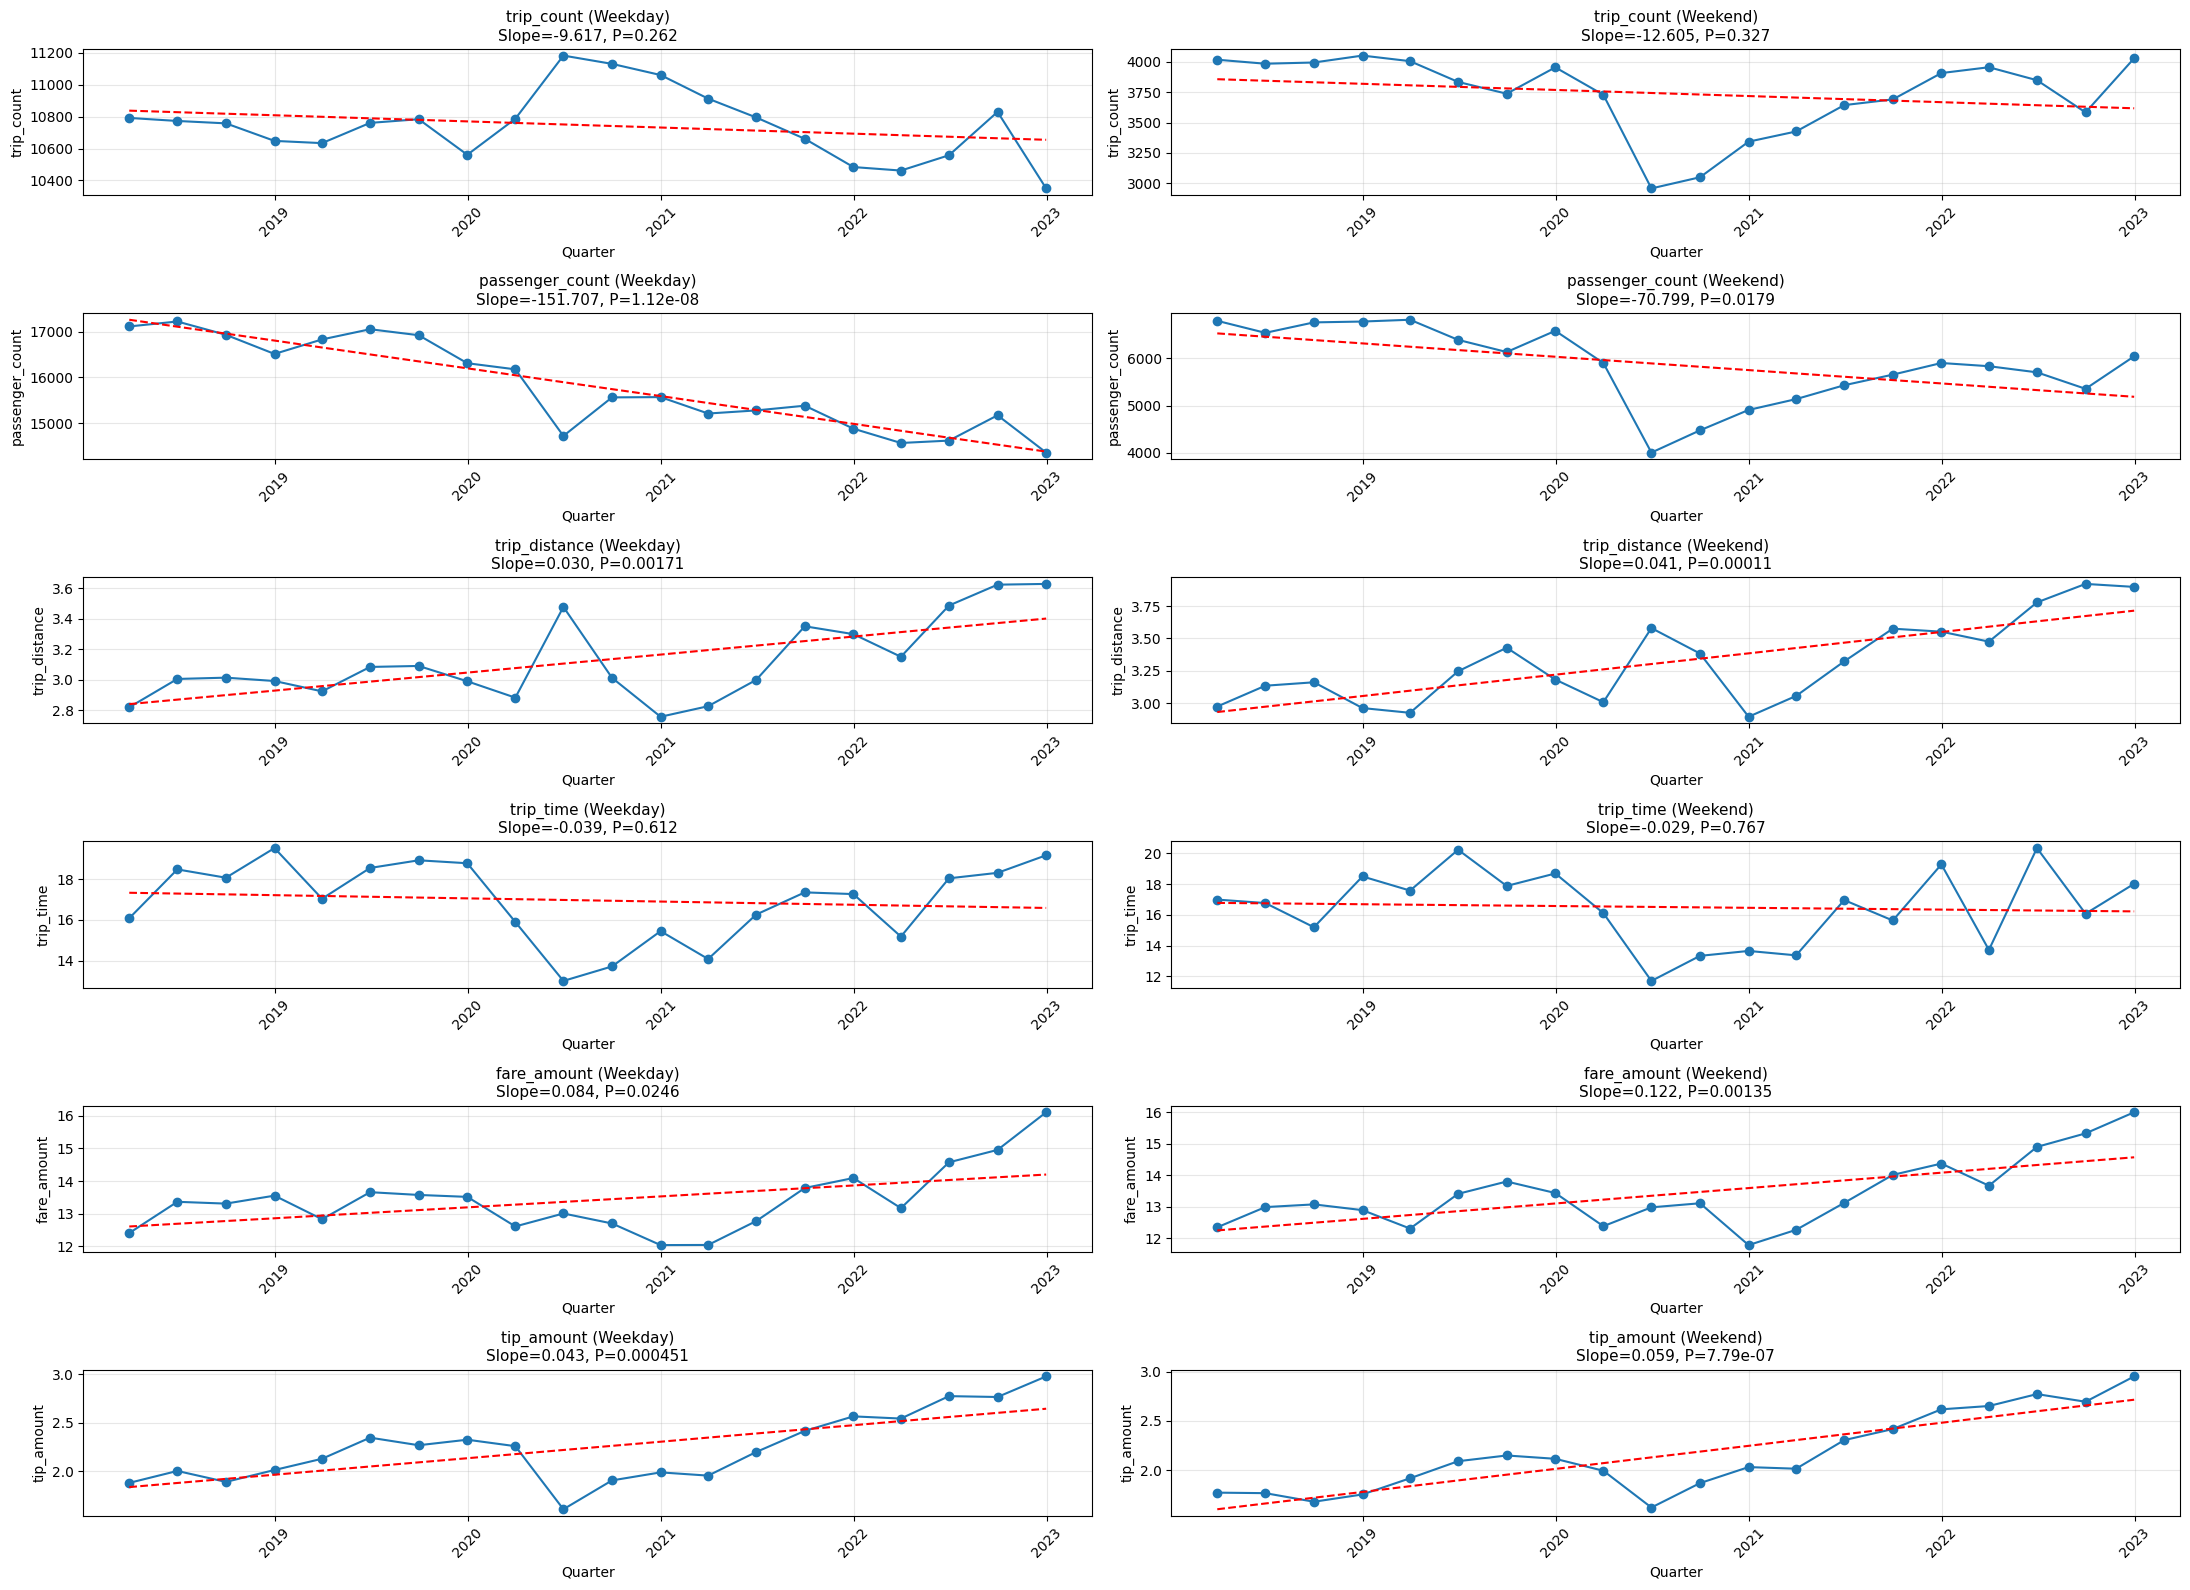

In [12]:
# Remove the last quarter as its incomplete
df_filtered = df[df['tpep_pickup_datetime'] < '2023-01-01'].copy()

# Copy df to do manipulations for plotting
df_plot = df_filtered.set_index('tpep_pickup_datetime')

# Add a new dummy column for number of trips per day
df_plot['trip_count'] = 1

# aggregate for each weekday/weekend group
agg_weekday = df_plot[df_plot['weekday_flag'] == False].resample('QE').agg(agg_dict)
agg_weekend = df_plot[df_plot['weekday_flag'] == True].resample('QE').agg(agg_dict)

# Store aggregations for easy access
agg_data = {False: agg_weekday, True: agg_weekend}

# Prepare figure with 12 plots
fig, axes = plt.subplots(6, 2, figsize=(22, 16))
axes = np.array(axes)  # use two-dimensions for column behaviour

# Make a plot for each feature and divide in weekday/weekend
for i, col in enumerate(cols_analyze):
    for j, flag in enumerate([False, True]):
        # Get data
        agg = agg_data[flag]
        vals = agg[col]

        # Prepare x-axis and x-values for plot
        quarters = agg.index
        x_numeric = np.arange(len(quarters))
        
        # Plot values
        ax = axes[i, j]
        ax.plot(quarters, vals, marker='o', label='Daten')
        
        # Calculate trend using statsmodels OLS
        vals_clean = vals.fillna(0)
        X = sm.add_constant(x_numeric)
        model = sm.OLS(vals_clean, X).fit()
        trend_vals = model.predict(X)
        slope = model.params.iloc[1]
        p = model.pvalues.iloc[1]

        # Plot trend line
        ax.plot(quarters, trend_vals, '--', color='red')
        
        # Format plot
        label = 'Weekend' if flag else 'Weekday'
        ax.set_title(f"{col} ({label})\nSlope={slope:.3f}, P={p:.3g}", fontsize=11)
        ax.set_ylabel(col)
        ax.set_xlabel('Quarter')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

There are no obvious differences between weekday and weekends for the most part. Trip and passenger count are the outliers from this observation. Weekday trips decline much faster while weekend ones go up after the covid break albeit overall being less. To remove seasonal components and get robust estimates for final trend extractions a STL decomposition of the time series will be performed for the analyzed features with a significant linear trend apart from distance. Instead `trip_count` will be included. The seasonal parameter will be set to weekly for all features as that makes most sense for daily data initially and is also supported by `trip_count` and `passenger_coount` having different behaviour between weekdays and weekends. This analysis will conclude the notebook.

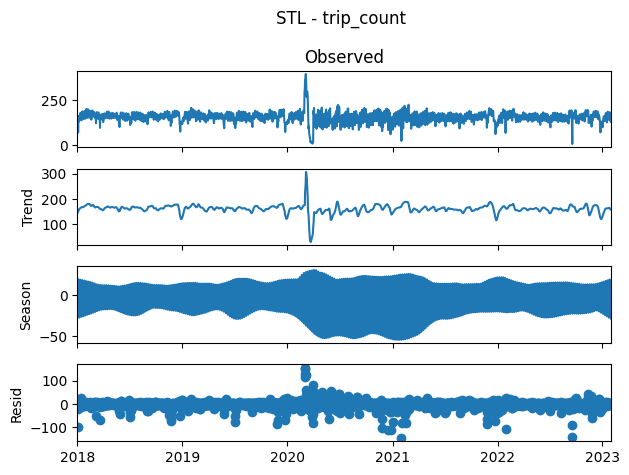

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     17.10
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           3.71e-05
Time:                        18:20:03   Log-Likelihood:                -7904.6
No. Observations:                1857   AIC:                         1.581e+04
Df Residuals:                    1855   BIC:                         1.582e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.0983      0.793    205.764      0.0

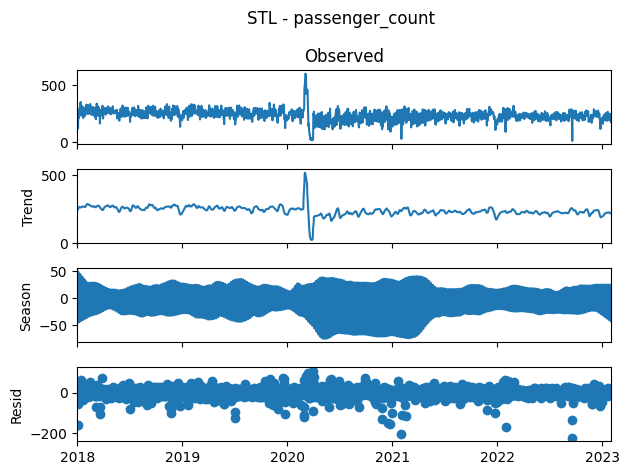

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     376.1
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           1.94e-76
Time:                        18:20:03   Log-Likelihood:                -9059.9
No. Observations:                1857   AIC:                         1.812e+04
Df Residuals:                    1855   BIC:                         1.813e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        263.5251      1.477    178.463      0.0

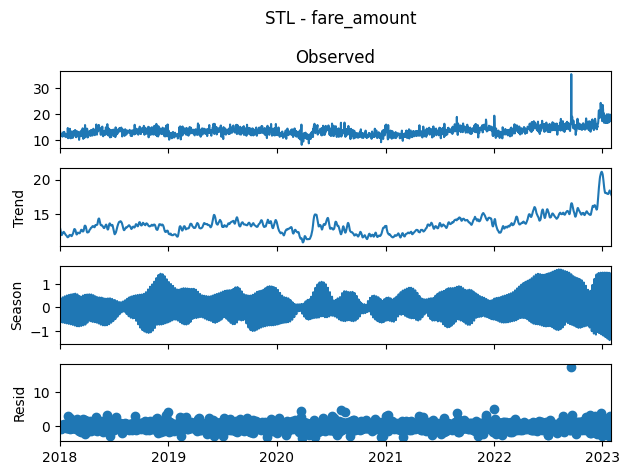

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     704.9
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          6.36e-132
Time:                        18:20:03   Log-Likelihood:                -2913.3
No. Observations:                1857   AIC:                             5831.
Df Residuals:                    1855   BIC:                             5842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2308      0.054    226.822      0.0

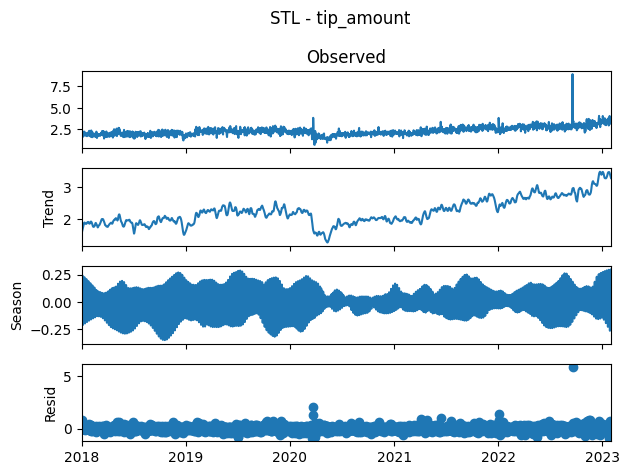

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     2216.
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          5.79e-319
Time:                        18:20:04   Log-Likelihood:                -237.74
No. Observations:                1857   AIC:                             479.5
Df Residuals:                    1855   BIC:                             490.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7024      0.013    133.358      0.0

In [13]:
# Which features to analyze over time, with different aggregate functions
num_cols = ['fare_amount', 'tip_amount']
cat_cols = ['trip_count', 'passenger_count']

# all features for aggregation
cols_analyze = cat_cols + num_cols

# Copy df to do manipulations for plotting
df_stl = df.copy().set_index('tpep_pickup_datetime')

# Add a new dummy column for number of trips per day
df_stl['trip_count'] = 1 

# Create different aggregations based on column type
agg_dict = {}
for col in cols_analyze:
    if col in num_cols:
        agg_dict[col] = ['mean']  # mean for numerical columns
    elif col == 'trip_count':
        agg_dict[col] = 'count' # count for trip counts
    else:
        agg_dict[col] = ['sum']  # sum for categorical columns

# Aggregate data for each day
agg_data = df_stl[cols_analyze].resample('D').agg(agg_dict)

for col in cols_analyze:
    # Perform seasonal decomposition with additive model and LOESS
    # Using period=7 for weekly seasonality and slightly higher
    # seasonal value as advised in the manual
    stl = STL(agg_data[col], period=7, seasonal=15, robust=True)
    res_robust = stl.fit()
    fig = res_robust.plot()
    plt.suptitle(f'STL - {col}', x=0.54)        
    # Show plot
    plt.tight_layout()
    plt.show()
    
    # Calculate OLS trend on the STL trend component
    trend = res_robust.trend.values
    x_numeric = np.arange(len(trend))
    X = sm.add_constant(x_numeric)
    model = sm.OLS(trend, X).fit()
    print(model.summary())



### Results of STL

As we can see the decomposition shows random residuals for the most part, indicating an overall good extraction of seasonal and trend components. There are some outliers, especially again the start of the covid pandemic which indicates again that some kind of handling is required for this. It's not straightforward though and depends on the overall goal of the analysis. The linear trend after decomposition is almost the same as before decomposition and still significant in all cases. The overall fit is not very good for the counts when looking at the summary statistics. This should be mostly stem from the outliers. For the fare and tip amount the fit is a bit better but not perfect. Still it gives a feel for the overall trend in the data which is slightly negative for trips and passengers and slightly positive for fares and tips. 

## Summary of trend extraction

It is possible to see some trends in the data for the analyzed columns. For the most part for numerical features those apear to be non-linear and happen mainly at the end of the observed time period. For trip and passenger numbers they are very small and calculation is likely influenced from outliers, especially around the start of Covid. Further analysis would be necessary to get a clearer picture.
